In [26]:
import numpy as np
from numpy.random import multivariate_normal as mvn
from scipy.stats import bernoulli
import matplotlib.pyplot as plt
from cycler import cycler

import sys
sys.path.insert(1,'../')
from mfvi_main import *
from lmc_algorithm import langevin_monte_carlo
from BayesianUtils import *

In [27]:
import numpy as np
import pymc3 as pm
import arviz as az
from scipy.special import expit  # For logistic function
from scipy.stats import bernoulli, multivariate_normal as mvn

## Bayesian logistic regression

We first establish the problem parameters by defining $\{(X_i,Y_i)\}_{i=1}^n$ pairs of randomly generated data. We assume access to $V$ and $\nabla V$ as in standard Bayesian settings.

In [28]:
d = 20
n_data = 100 

true_theta = mvn(np.zeros(d), np.eye(d))

Xdata = mvn(np.zeros(d),np.eye(d),size=n_data)
maxeig = np.linalg.eig(Xdata.T @ Xdata)[0][0]
Xdata = Xdata / np.sqrt(maxeig)
probs = softmax(Xdata @ true_theta)
Ydata = bernoulli.rvs(probs)

V = lambda theta: V_logistic(theta, Y=Ydata, X=Xdata)
gradV = lambda theta: gradV_logistic(theta, Y=Ydata, X=Xdata)

TypeError: __call__() got an unexpected keyword argument 'size'

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta]


/Users/bohanwu/Library/Python/3.9/lib/python/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.


MCMC Summary:
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
theta[0]  -0.022  0.940  -1.722    1.769      0.012    0.015    5926.0   
theta[1]  -0.232  0.935  -1.935    1.561      0.012    0.015    6028.0   
theta[2]   0.218  0.898  -1.461    1.829      0.011    0.014    6532.0   
theta[3]   0.019  0.934  -1.783    1.715      0.013    0.015    5319.0   
theta[4]  -0.115  0.916  -1.876    1.561      0.013    0.015    4760.0   
theta[5]  -0.089  0.958  -1.935    1.632      0.012    0.016    6363.0   
theta[6]   0.107  0.956  -1.617    1.977      0.013    0.017    5237.0   
theta[7]  -0.028  0.932  -1.894    1.645      0.013    0.015    5114.0   
theta[8]   0.156  0.947  -1.547    1.984      0.012    0.016    6037.0   
theta[9]   1.025  0.917  -0.766    2.625      0.012    0.012    5928.0   
theta[10] -0.330  0.910  -2.042    1.379      0.012    0.014    5687.0   
theta[11]  0.342  0.933  -1.322    2.222      0.013    0.015    5151.0   
theta[12] -0.026  0.962 

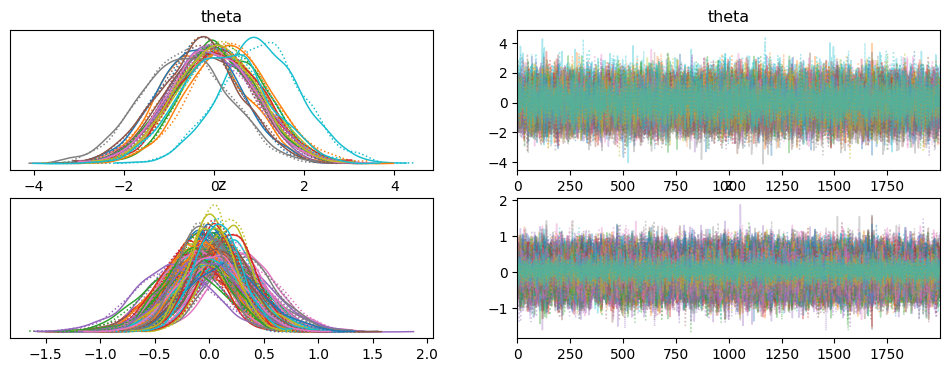

Estimated probabilities (MCMC): [[0.50975249 0.50849391 0.56670891 ... 0.55752612 0.55765684 0.63976124]
 [0.50420687 0.44166281 0.4910753  ... 0.54567754 0.49790341 0.53991315]
 [0.52726853 0.52904409 0.54825121 ... 0.51249911 0.50198435 0.55833613]
 ...
 [0.49464386 0.44495271 0.51779851 ... 0.44890172 0.49485698 0.41417958]
 [0.49713912 0.43297418 0.51173666 ... 0.48367624 0.51982555 0.48447861]
 [0.53919053 0.48711392 0.48585815 ... 0.52014934 0.51894547 0.43219645]]
Model accuracy (MCMC): 0.0


/var/folders/ky/8hp3nd491rdgmwgfgrzsf_xc0000gn/T/ipykernel_74291/4237871583.py:32: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  accuracy_mcmc = np.mean((ppc_probs_mcmc > 0.5).astype(int) == Ydata)


Finished [100%]: Average Loss = 69.47
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/bohanwu/Library/Python/3.9/lib/python/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/bohanwu/Library/Python/3.9/lib/python/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.wa

VI Summary:
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
theta[0]  -0.028  1.026  -1.861    1.870      0.024    0.017    1867.0   
theta[1]  -0.219  1.032  -2.190    1.692      0.023    0.016    2014.0   
theta[2]   0.225  1.026  -1.745    2.118      0.023    0.017    2066.0   
theta[3]   0.024  1.043  -1.967    1.942      0.022    0.016    2147.0   
theta[4]  -0.102  1.039  -1.941    1.990      0.024    0.017    1921.0   
theta[5]  -0.078  0.988  -1.911    1.790      0.023    0.016    1843.0   
theta[6]   0.136  1.042  -1.927    1.977      0.024    0.017    1890.0   
theta[7]  -0.030  1.031  -1.792    2.085      0.024    0.017    1909.0   
theta[8]   0.119  1.044  -1.850    2.037      0.023    0.017    1978.0   
theta[9]   1.047  1.023  -0.910    2.844      0.023    0.016    2034.0   
theta[10] -0.382  1.010  -2.237    1.542      0.023    0.016    2012.0   
theta[11]  0.379  1.050  -1.453    2.531      0.023    0.017    2023.0   
theta[12]  0.007  1.021  -

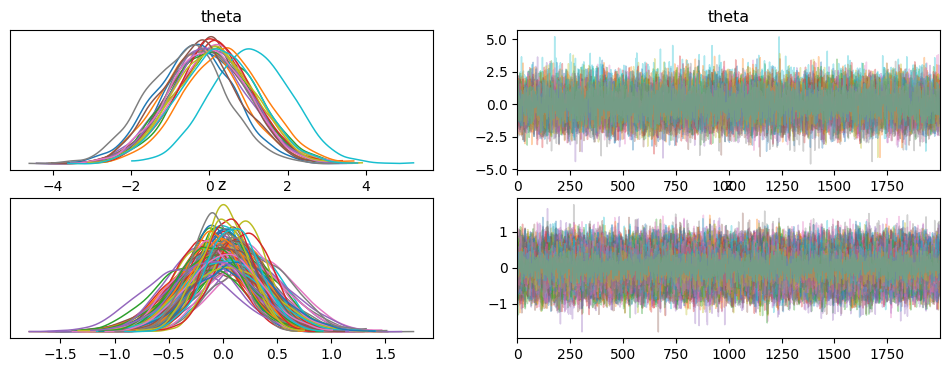

AttributeError: 'MultiTrace' object has no attribute 'posterior'

In [29]:
# Create a PyMC3 model
with pm.Model() as model:
    # Priors for the regression coefficients
    theta = pm.MvNormal('theta', mu=np.zeros(d), cov=np.eye(d), shape=d)

    # Linear combination
    z = pm.Deterministic('z', pm.math.dot(Xdata, theta))

    # Likelihood (sampling distribution) of the observations
    y_obs = pm.Bernoulli('y_obs', logit_p=z, observed=Ydata)

    # Inference using MCMC
    trace_mcmc = pm.sample(2000, return_inferencedata=True, cores=1)

# Summary of the trace from MCMC
summary_mcmc = az.summary(trace_mcmc, var_names=["theta"])
print("MCMC Summary:")
print(summary_mcmc)

# Plot the posterior distributions for MCMC
az.plot_trace(trace_mcmc)
plt.show()

# Print estimated probabilities for MCMC
posterior_theta_mcmc = trace_mcmc.posterior['theta'].values
ppc_logits_mcmc = Xdata @ posterior_theta_mcmc.mean(axis=0).T
ppc_probs_mcmc = expit(ppc_logits_mcmc)

print("Estimated probabilities (MCMC):", ppc_probs_mcmc)

# Evaluate the model performance for MCMC
accuracy_mcmc = np.mean((ppc_probs_mcmc > 0.5).astype(int) == Ydata)
print("Model accuracy (MCMC):", accuracy_mcmc)

# Variational Inference
with model:
    approx = pm.fit(n=20000, method='advi')

trace_vi = approx.sample(2000)

# Summary of the trace from VI
summary_vi = az.summary(trace_vi, var_names=["theta"])
print("VI Summary:")
print(summary_vi)

# Plot the posterior distributions for VI
az.plot_trace(trace_vi)
plt.show()

# Print estimated probabilities for VI
posterior_theta_vi = trace_vi.posterior['theta'].values
ppc_logits_vi = Xdata @ posterior_theta_vi.mean(axis=0).T
ppc_probs_vi = expit(ppc_logits_vi)

print("Estimated probabilities (VI):", ppc_probs_vi)

# Evaluate the model performance for VI
accuracy_vi = np.mean((ppc_probs_vi > 0.5).astype(int) == Ydata)
print("Model accuracy (VI):", accuracy_vi)

# Plot the comparison of the two methods
az.plot_posterior(trace_mcmc, var_names=["theta"], hdi_prob=0.95, point_estimate='mean', ref_val=0, kind='kde', round_to=2, bw=1)
az.plot_posterior(trace_vi, var_names=["theta"], hdi_prob=0.95, point_estimate='mean', ref_val=0, kind='kde', round_to=2, bw=1)
plt.show()

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/bohanwu/Library/Python/3.9/lib/python/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


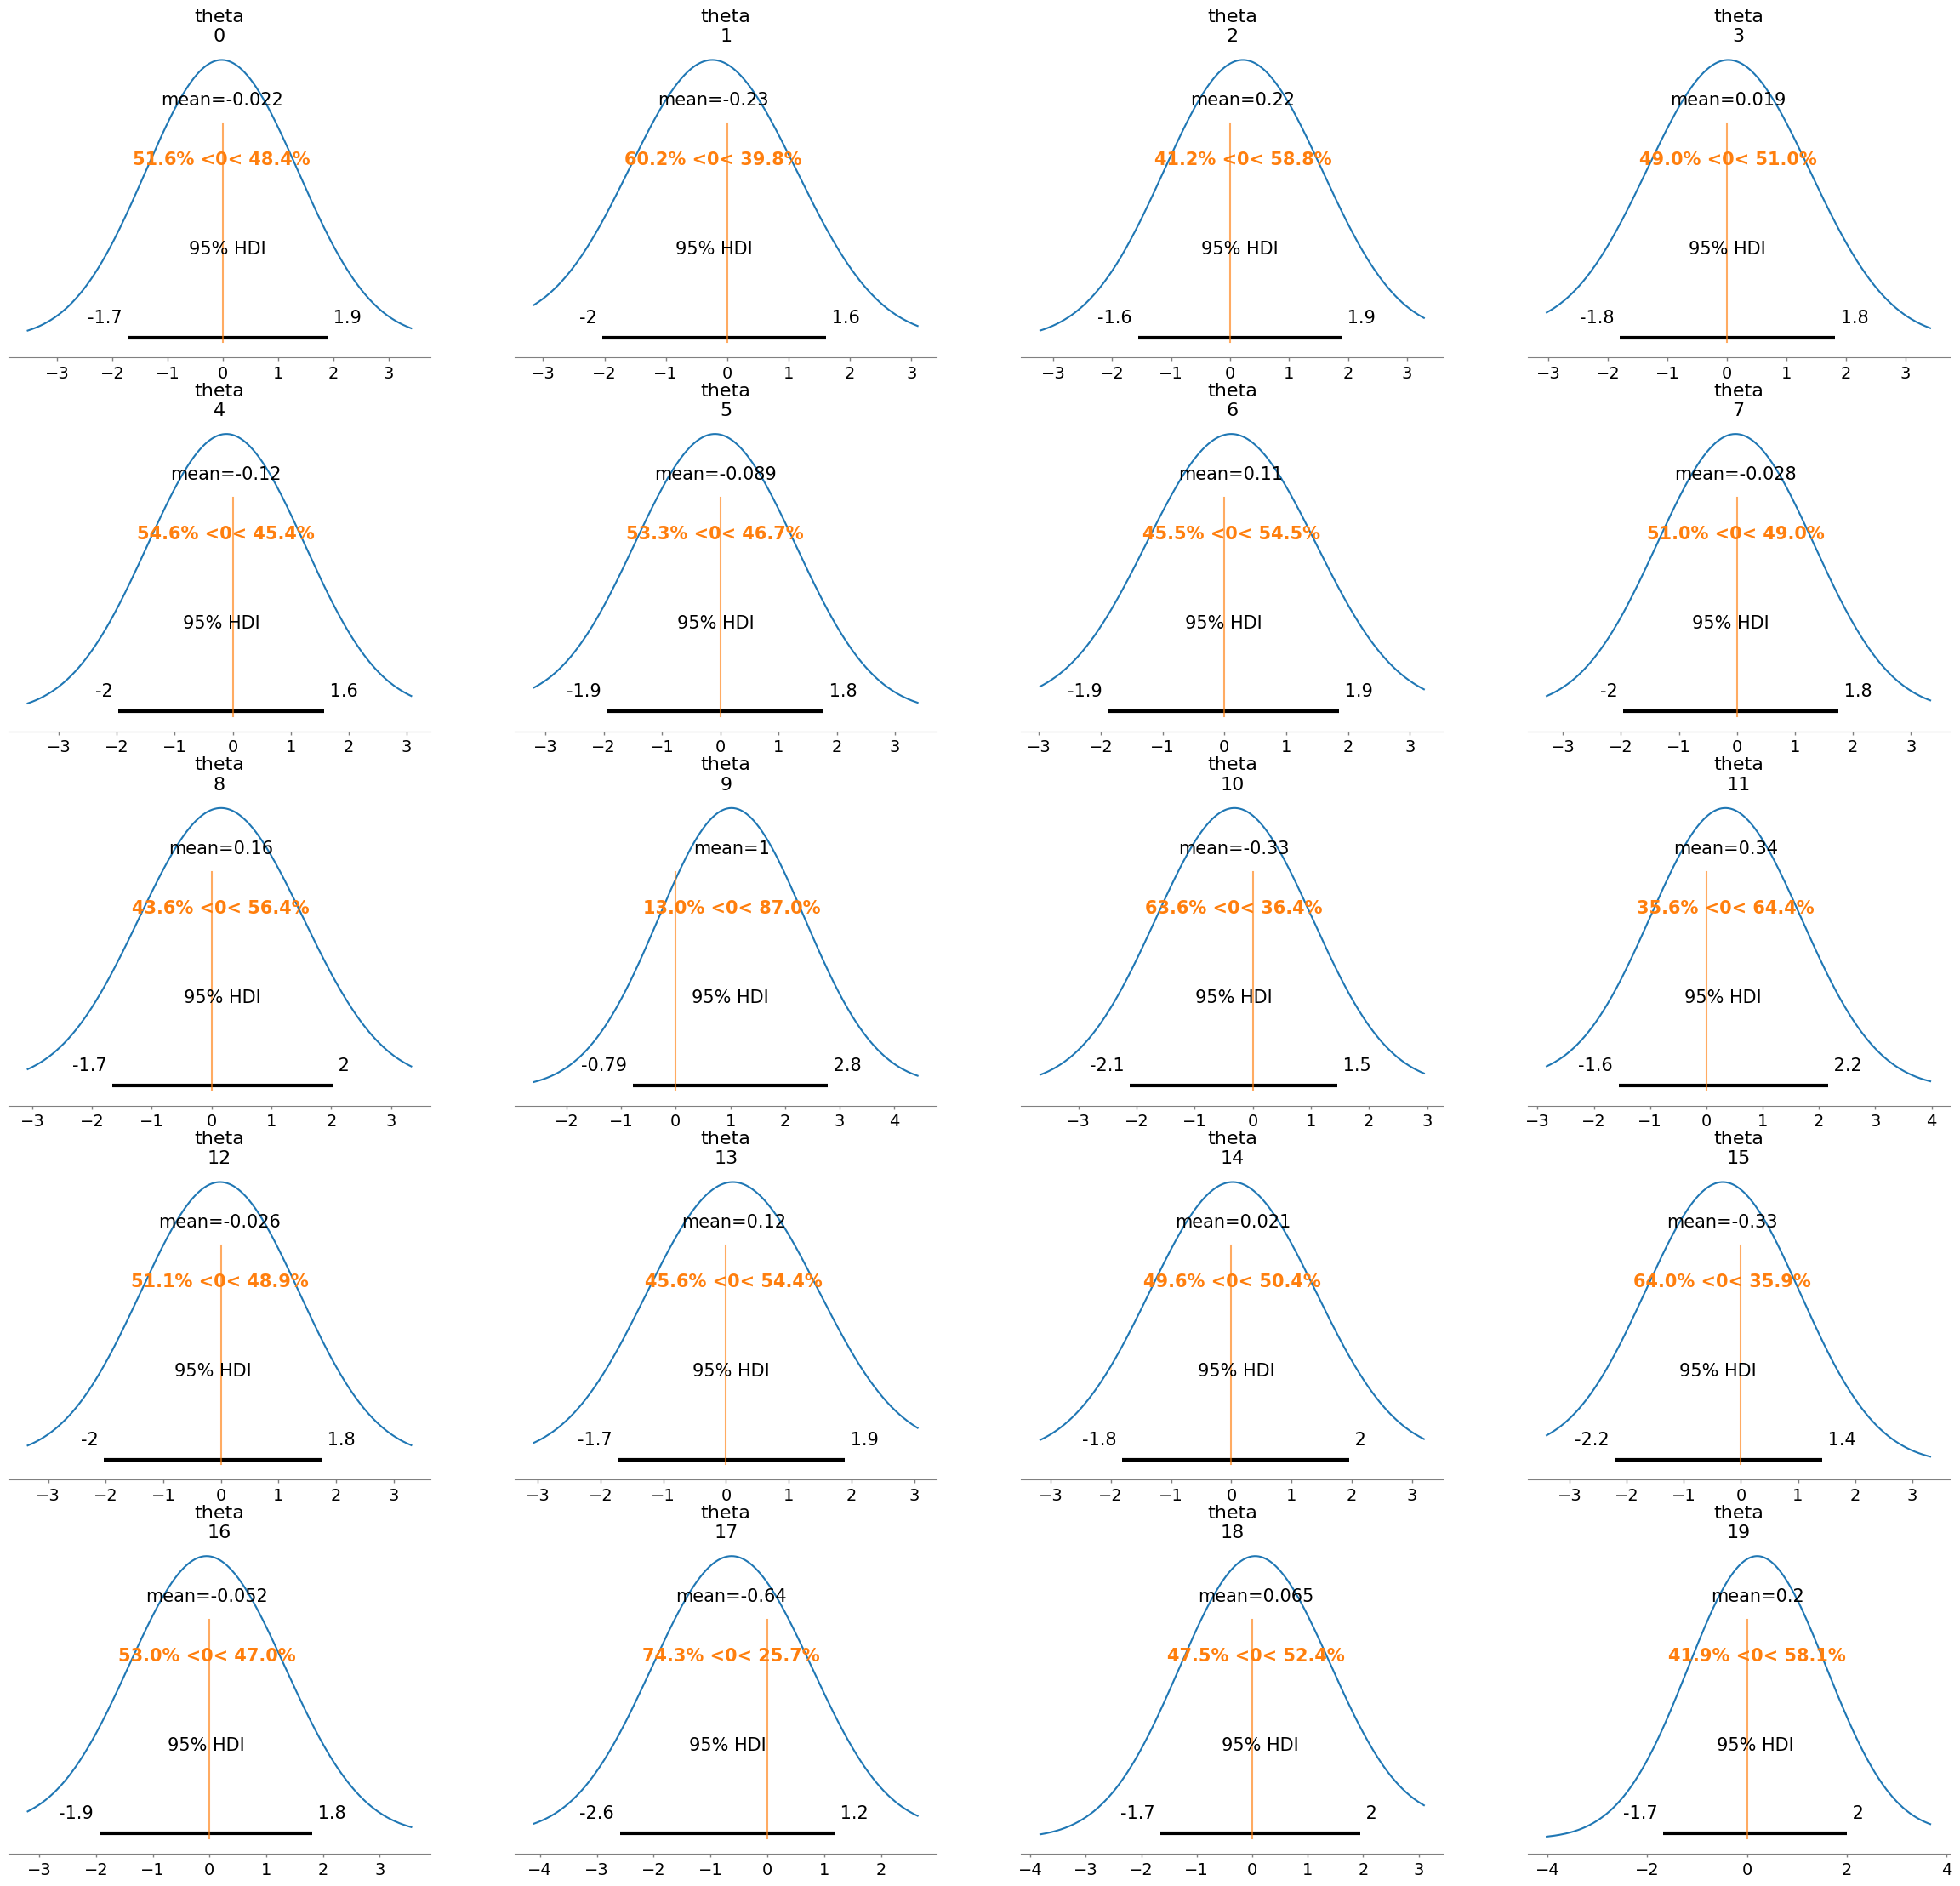

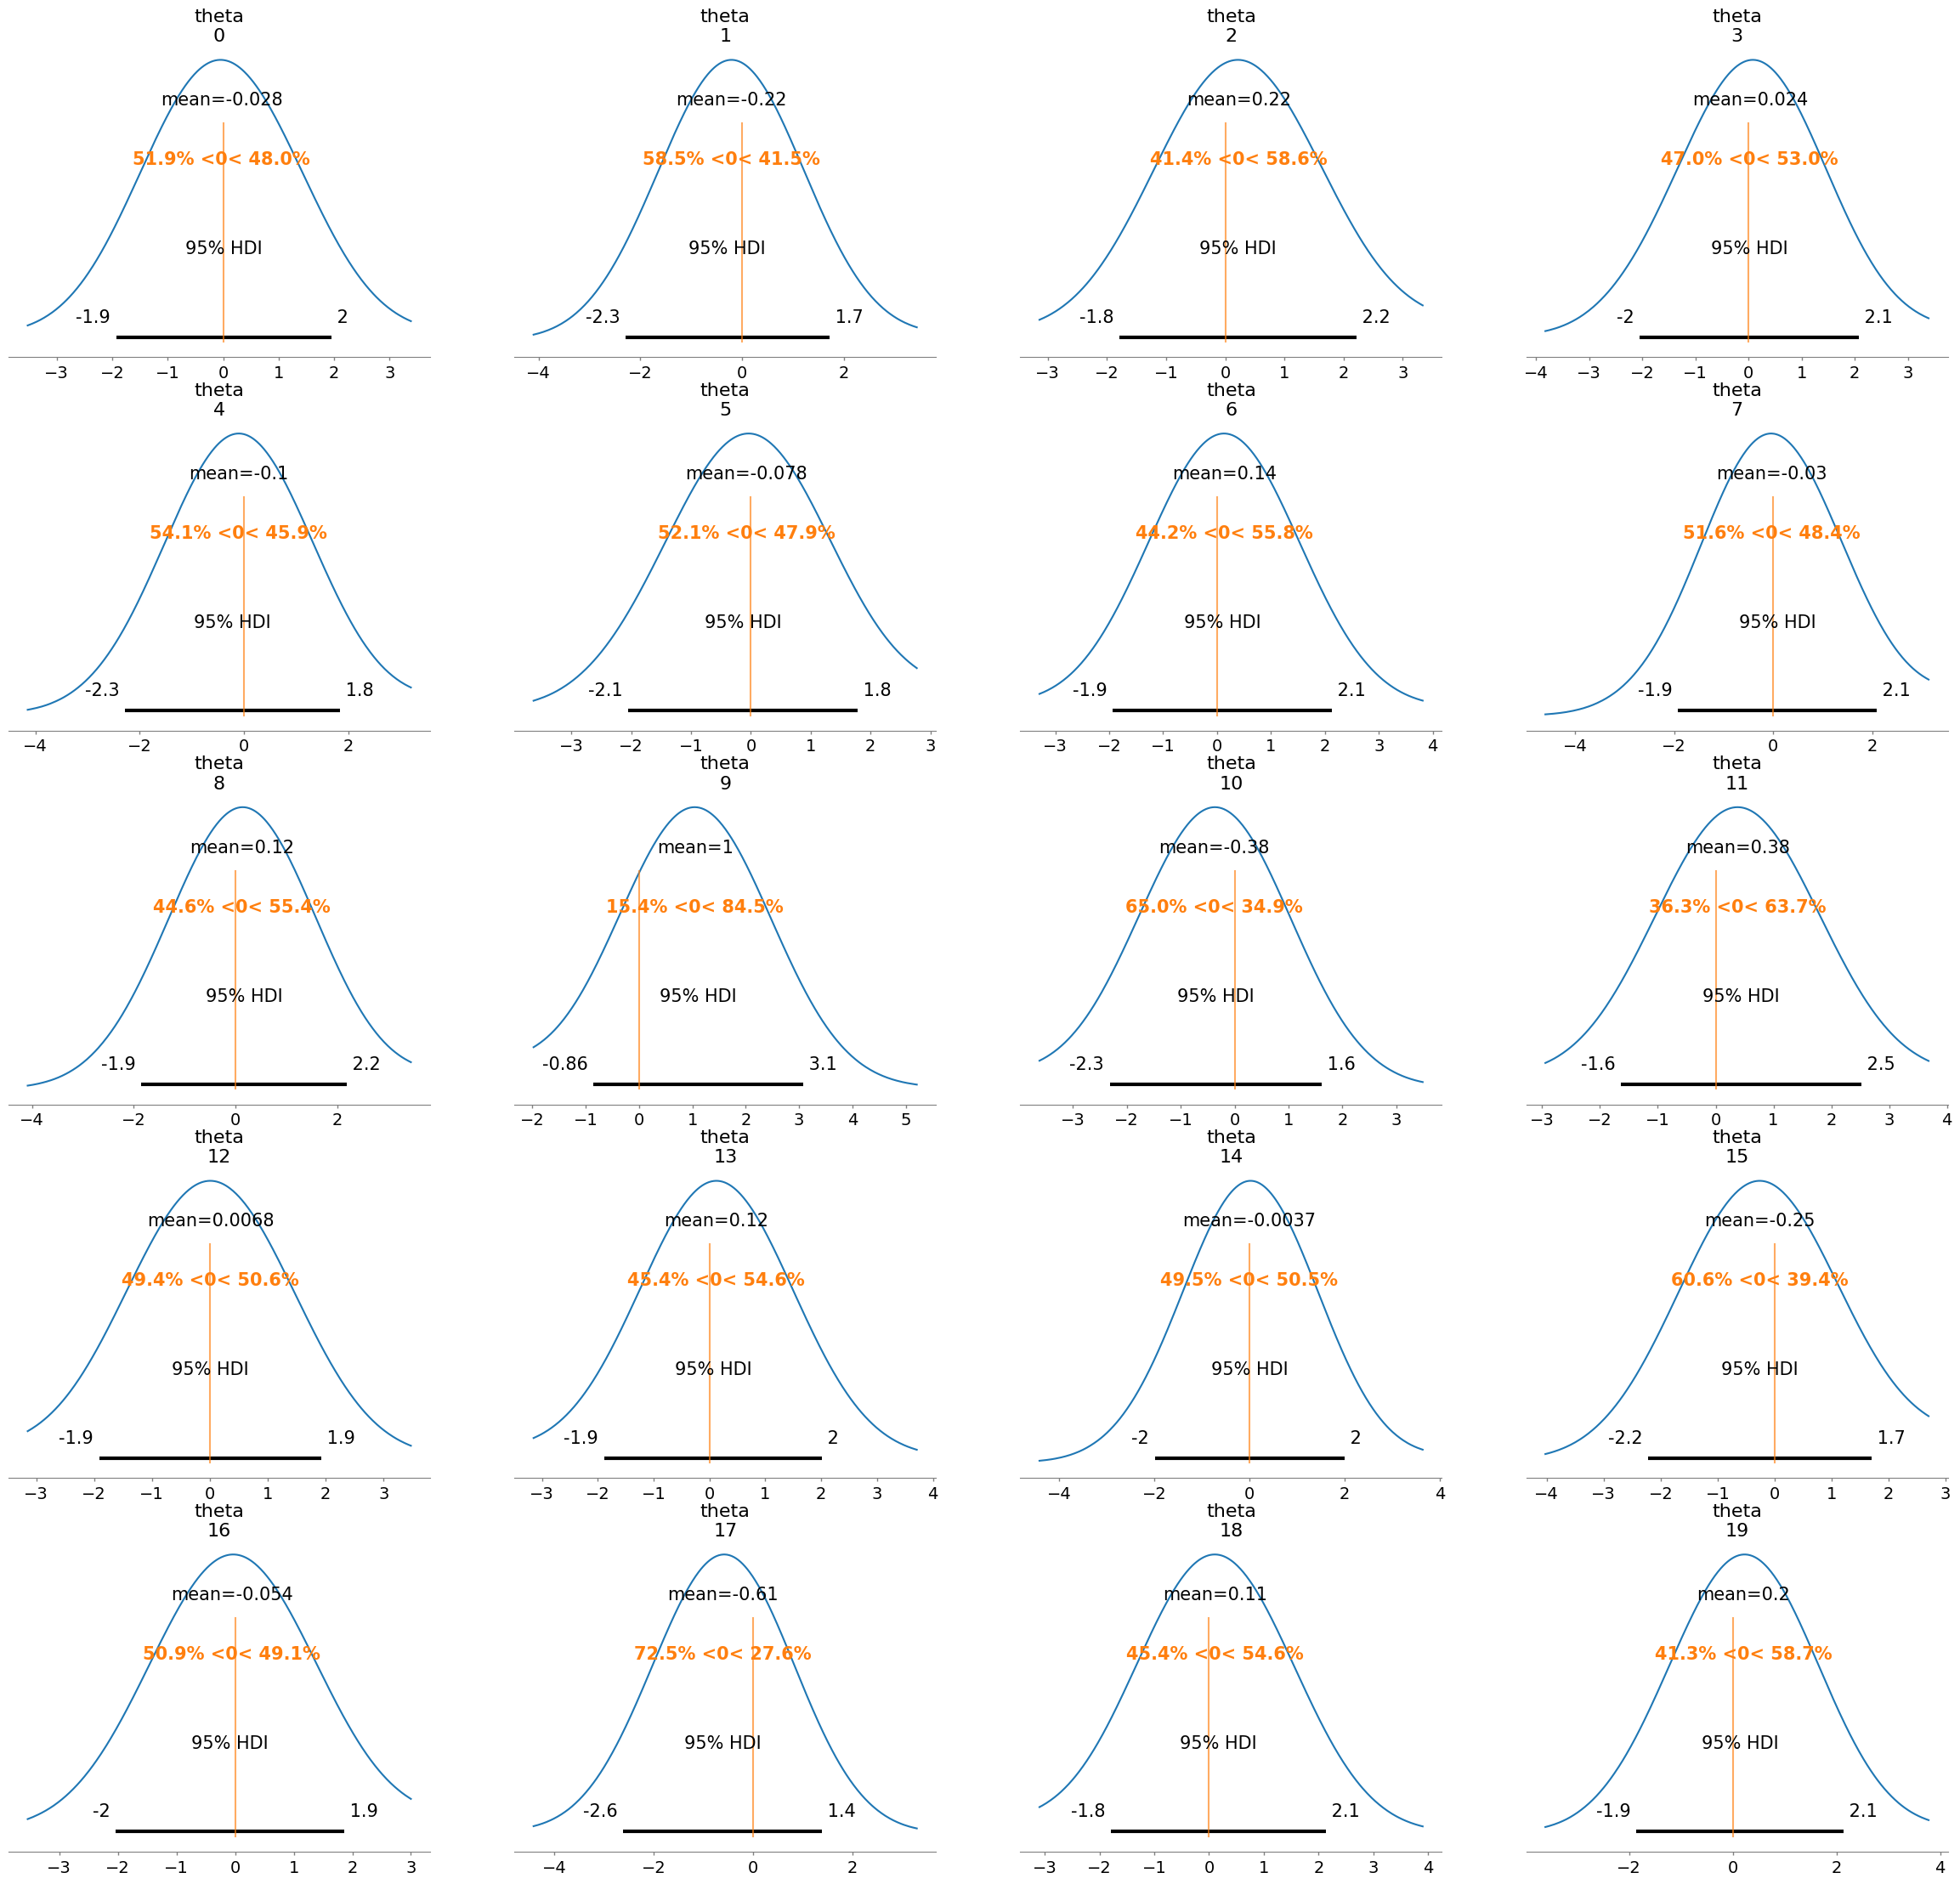

In [30]:
# Plot the comparison of the two methods
az.plot_posterior(trace_mcmc, var_names=["theta"], hdi_prob=0.95, point_estimate='mean', ref_val=0, kind='kde', round_to=2, bw=1)
az.plot_posterior(trace_vi, var_names=["theta"], hdi_prob=0.95, point_estimate='mean', ref_val=0, kind='kde', round_to=2, bw=1)
plt.show()

## Langevin Monte Carlo (LMC)

We compare against LMC, which is easy to run given query access to $\nabla V$.

In [31]:
Nmcmc = 2000
h=0.01
iters=5000

X_LMC = langevin_monte_carlo(gradV, Nmcmc, d, h, iters=iters)

## Mean-field VI

We establish our model parameters, and then run our algorithm

In [32]:
### Establish approximating family M
mesh=0.2
trunc=2.9

MFVI_obj = MFVI(V, gradV, mesh, trunc,d)

### Optimization parameters
alpha = 0.1
step_size = 1e-2
step_sizev = 1e-2
num_iters = 2000
batch_size = 2000
lamb0 = np.ones((d, MFVI_obj.J))/(d*MFVI_obj.J)

In [33]:
MFVI_obj.SPGD(alpha, step_size, step_sizev, lamb0, batch_size=batch_size,num_iters=num_iters)

Iter: 50
Iter: 100
Iter: 150
Iter: 200
Iter: 250
Iter: 300
Iter: 350
Iter: 400
Iter: 450
Iter: 500
Iter: 550
Iter: 600
Iter: 650
Iter: 700
Iter: 750
Iter: 800
Iter: 850
Iter: 900
Iter: 950
Iter: 1000
Iter: 1050
Iter: 1100
Iter: 1150
Iter: 1200
Iter: 1250
Iter: 1300
Iter: 1350
Iter: 1400
Iter: 1450
Iter: 1500
Iter: 1550
Iter: 1600
Iter: 1650
Iter: 1700
Iter: 1750
Iter: 1800
Iter: 1850
Iter: 1900
Iter: 1950


## Generate + visualize

We compute samples following our mean-field approximation algorithm, and visually compare to LMC

In [34]:
Nmcmc = 2000
mfapprox_BLogR = MFVI_obj.gen_mfapprox(Nmcmc)

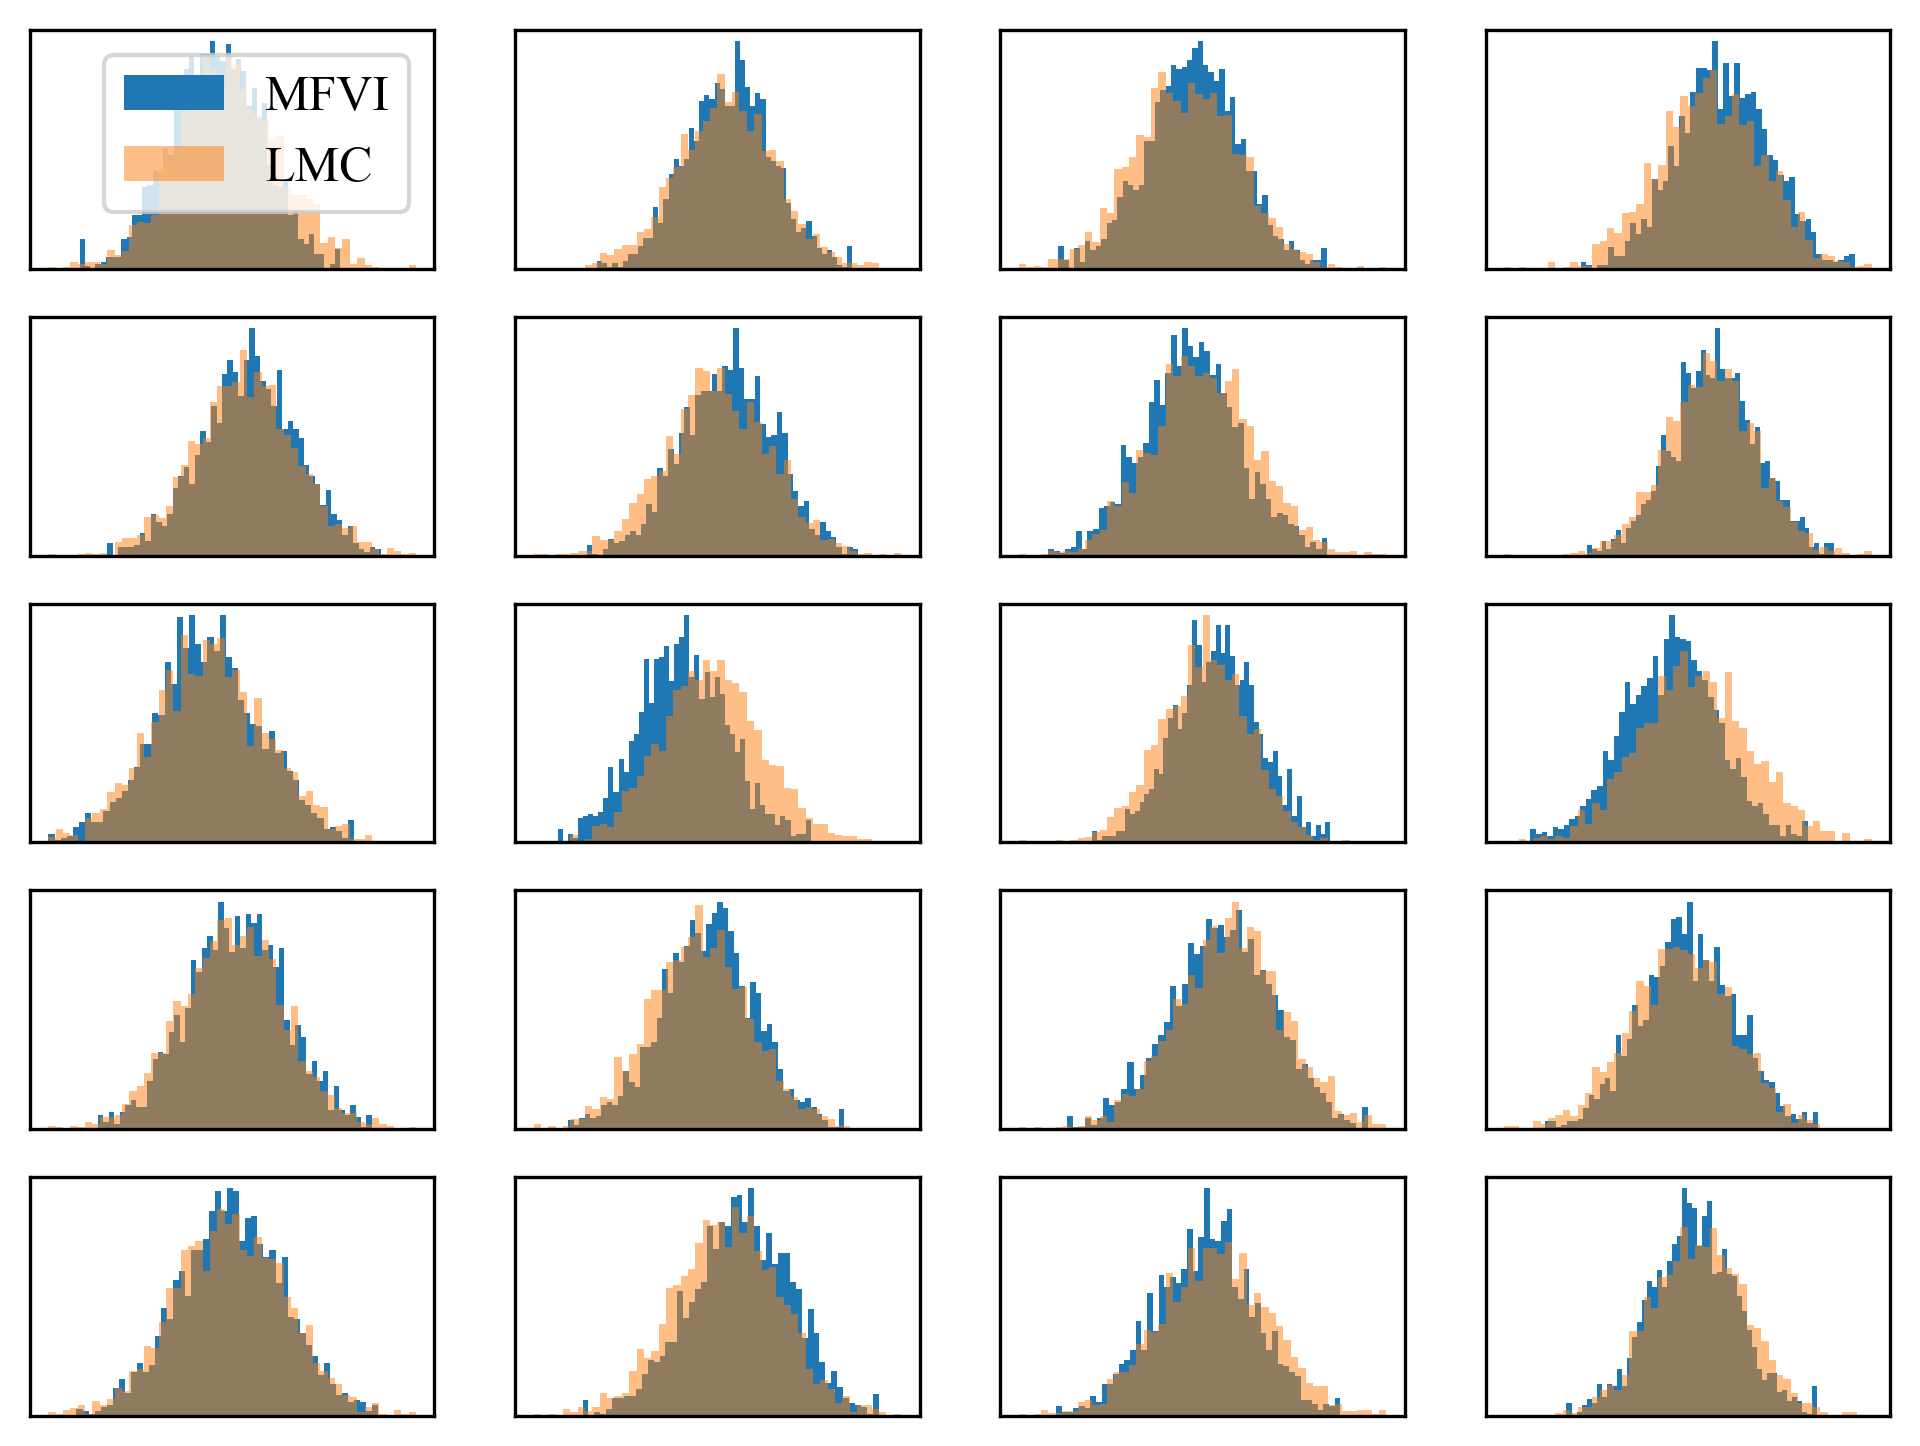

In [35]:
nrow = 5
ncol = 4
plt.rcParams['font.family'] = 'Times New Roman'

fig, axs = plt.subplots(nrow,ncol, dpi=300, figsize=(8, 6))


for i in range(nrow):
    for j in range(ncol):
        ax = axs[i][j]
        d_ = ncol*i+j
        if i == j == 0:
            ax.hist(mfapprox_BLogR[:,d_], bins=50, alpha=1, density=True,label='MFVI')
            ax.hist(X_LMC[:,d_], bins=50, alpha=0.5, density=True,label='LMC')
            ax.legend(fontsize='12')
        else:
            ax.hist(mfapprox_BLogR[:,d_], bins=50, alpha=1, density=True)
            ax.hist(X_LMC[:,d_], bins=50, alpha=0.5, density=True)
        ax.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 

plt.show()

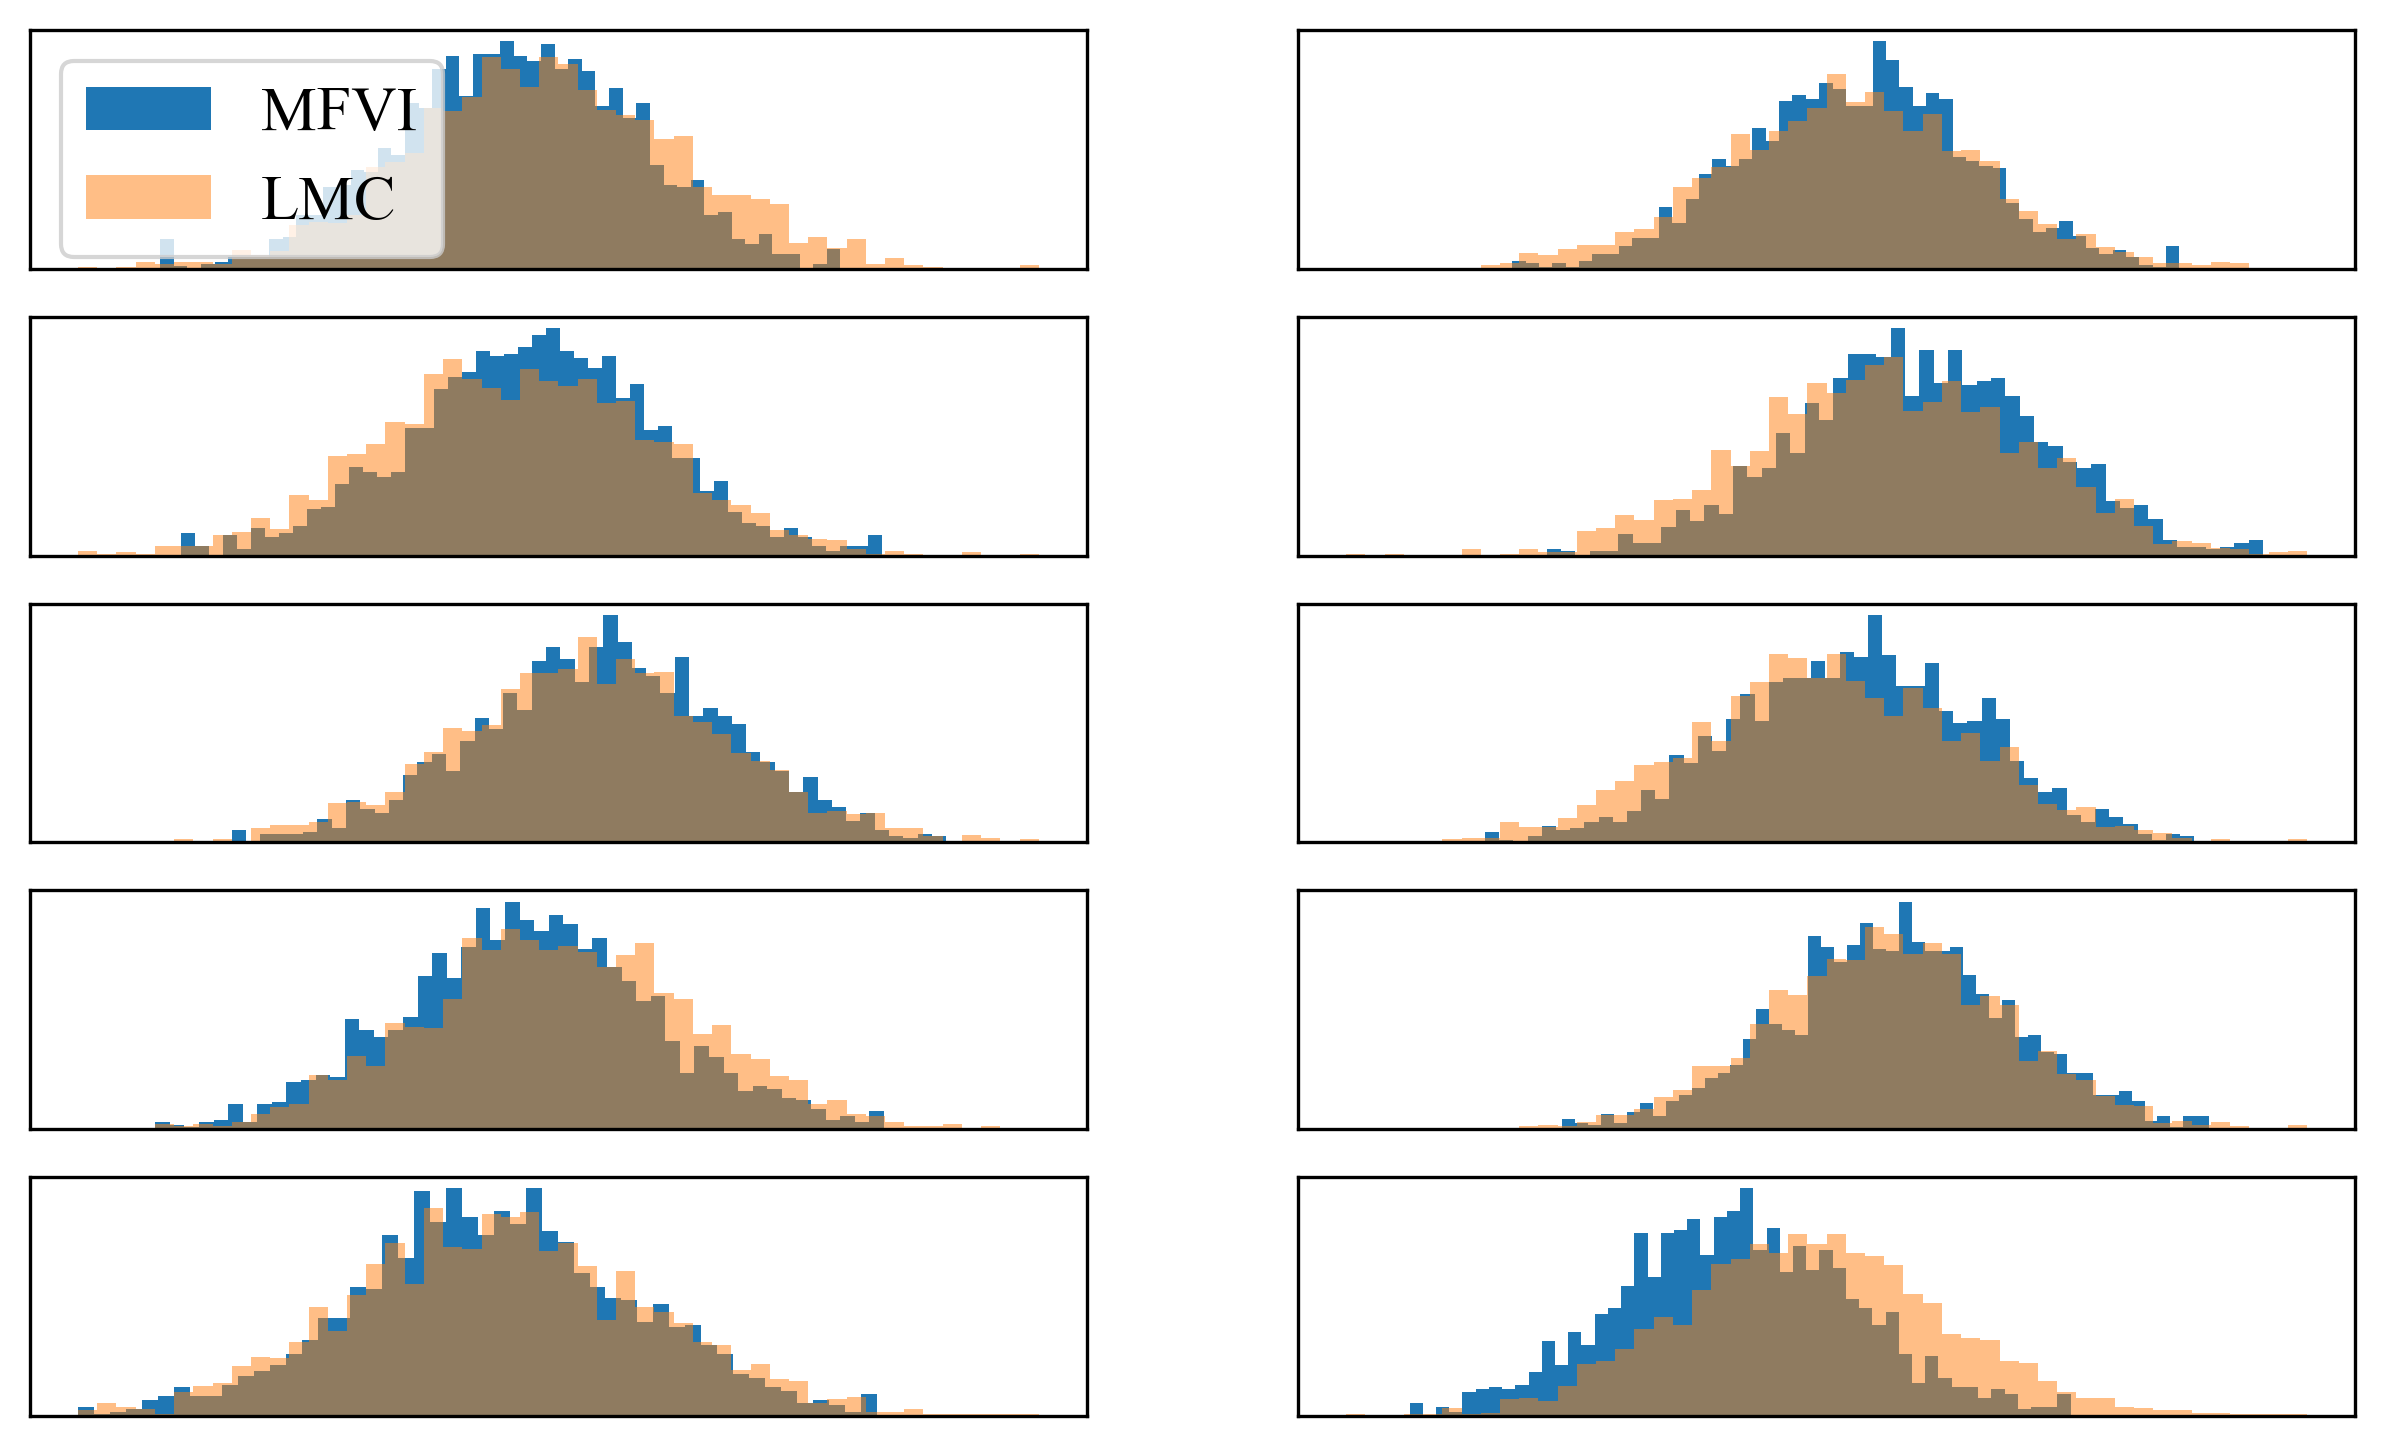

In [36]:
nrow = 5
ncol = 2
plt.rcParams['font.family'] = 'Times New Roman'

fig, axs = plt.subplots(nrow,ncol, dpi=300, figsize=(10, 6))


for i in range(nrow):
    for j in range(ncol):
        ax = axs[i][j]
        d_ = ncol*i+j
        if i == j == 0:
            ax.hist(mfapprox_BLogR[:,d_], bins=50, alpha=1, density=True,label='MFVI')
            ax.hist(X_LMC[:,d_], bins=50, alpha=0.5, density=True,label='LMC')
            ax.legend(fontsize='15',loc='upper left',)
        else:
            ax.hist(mfapprox_BLogR[:,d_], bins=50, alpha=1, density=True)
            ax.hist(X_LMC[:,d_], bins=50, alpha=0.5, density=True)
        ax.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
        
plt.show()